In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import sys

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
plt.rcParams.update({
    'figure.figsize': [7, 7],
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 7,
    'axes.titlesize': 8,
    'legend.frameon': True,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'lines.linewidth': 1,
    'figure.dpi': 150.0
})

## Fetch the data from GitHub

(Requires an API token)

In [ ]:
api_token = ''

def send_rest_request(url):
    headers = {'Authorization': f'token {api_token}'}
    r = requests.get(url=url, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    return r.json()

def send_graphql_request(query, variables):
    headers = {'Authorization': f'token {api_token}'}
    url = 'https://api.github.com/graphql'
    json = {'query':query, 'variables':variables}
    r = requests.post(url=url, json=json, headers=headers)
    r.raise_for_status() # Abort if unsuccessful request
    return r.json()

In [ ]:
query = """
query issueDates($cursor: String) {
  repository(owner: "NixOS", name: "nixpkgs") {
    issues(first: 100, after: $cursor) {
      pageInfo {
        endCursor
        hasNextPage
      }
      nodes {
        number
        createdAt
        closedAt
      }
    }
  }
}
"""

In [ ]:
fields = ['createdAt', 'closedAt']
issues = pd.DataFrame(columns=fields)
cursor = None
next_page = True

In [ ]:
while next_page:
    json = send_graphql_request(query, {'cursor': cursor})
    result = json['data']['repository']['issues']
    next_page = result['pageInfo']['hasNextPage']
    cursor = result['pageInfo']['endCursor']
    for issue in result['nodes']:
        number = issue['number']
        for field in fields:
            issues.loc[number, field] = issue[field]
    sys.stdout.write(f'Current issue: #{number}\r')
    sys.stdout.flush()

In [ ]:
issues.to_csv('nixpkgs-issues.csv')

## Analyze the data

(can be skipped to directly, by reusing the provided CSV file)

In [ ]:
issues = pd.read_csv('nixpkgs-issues.csv', index_col=0, parse_dates=['createdAt', 'closedAt'])

In [ ]:
issues = issues.assign(lifetime=(issues['closedAt'] - issues['createdAt']).apply(
    lambda dt: np.inf if pd.isnull(dt) else dt.total_seconds()
))

In [ ]:
lifetime = issues[
    (issues['createdAt'] > pd.to_datetime('2015-01-01T00:00:00Z')) &
    (issues['createdAt'] < pd.to_datetime('2019-01-01T00:00:00Z'))
].groupby(pd.Grouper(key='createdAt', freq="M"))['lifetime'].agg('describe')

In [ ]:
# This function computes the mean of all the values it gets until it encounters an infinity
def compute_mean(array):
    total = 0
    number = 0
    for x in array:
        if np.isfinite(x):
            total += x
            number += 1
        else:
            break
    return total / number

The average time to close 25% of the issues is 2 days 00:26:37.192708
The average time to close 50% of the issues is 52 days 18:43:55.989583
The average time to close 75% of the issues is 487 days 02:25:32.094827


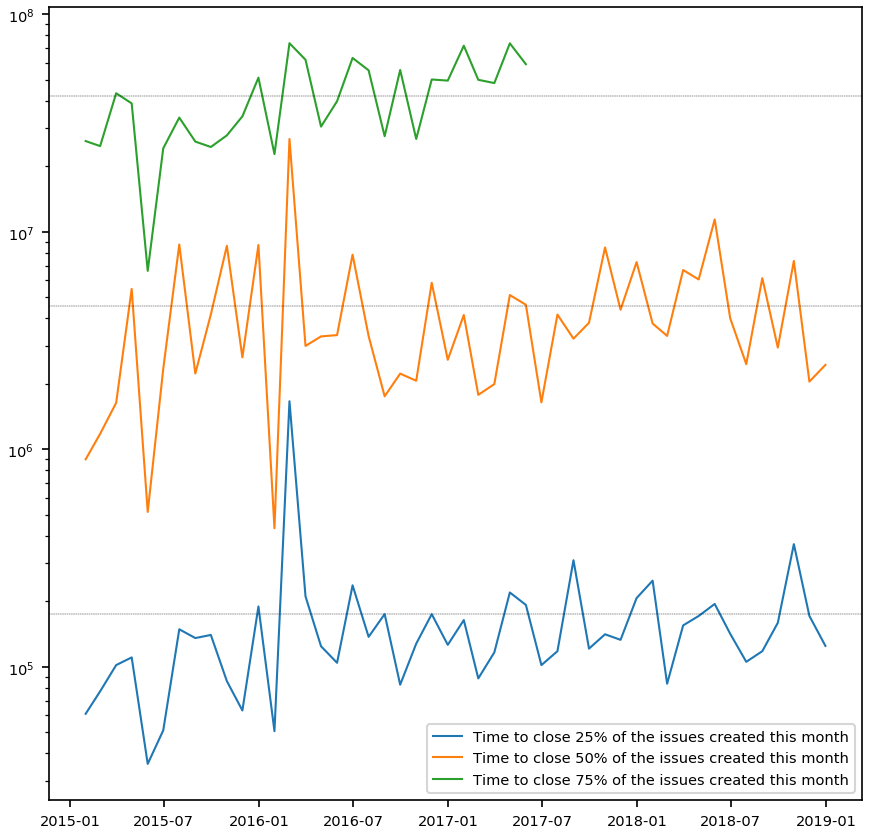

In [ ]:
for percentile in ['25%', '50%', '75%']:
    plt.plot(lifetime.index, lifetime[percentile], label=f'Time to close {percentile} of the issues created this month')
    percentile_lifetime = compute_mean(lifetime[percentile])
    plt.axhline(y=percentile_lifetime, color='black', lw=0.2, linestyle='--')
    print(f'The average time to close {percentile} of the issues is {pd.to_timedelta(percentile_lifetime, unit="seconds")}')
plt.yscale('log')
plt.legend()
plt.show()